In [1]:
import pandas as pd
import numpy as np
import ast
import pickle
from pathlib import Path
import multirecording_spikeanalysis as spike
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import linregress

cols = ['condition ', 'session_dir', 'all_subjects', 'tone_start_timestamp', 'tone_stop_timestamp']

# Load the data
df = pd.read_excel('rce_pilot_2_per_video_trial_labels.xlsx', usecols=cols, engine='openpyxl')

df2 = df.dropna() # Drop the rows missing data
df3 = df2.copy()
df3['all_subjects'] = df3['all_subjects'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) # Make the 'all_subjects' column readable as a list
df4 = df3[df3['all_subjects'].apply(lambda x: len(x) < 3)] # Ignore novel sessions for now

# Initialize an empty list to collect data for the new DataFrame
new_df_data = []

for _, row in df4.iterrows():
    session_dir = row['session_dir']
    subjects = row['all_subjects']
    condition = row['condition ']

    # Split session_dir on '_subj_' and take the first part only
    # This ensures everything after '_subj_' is ignored
    base_session_dir = session_dir.split('_subj_')[0]

    for subject in subjects:
        subject_formatted = subject.replace('.', '-')
        # Append formatted subject to the base session_dir correctly
        subj_recording = f"{base_session_dir}_subj_{subject_formatted}"
        new_df_data.append({
            'session_dir': session_dir,
            'subject': subject,
            'subj_recording': subj_recording,
            'condition': condition if condition in ['rewarded', 'omission', 'both_rewarded', 'tie'] else ('win' if str(condition) == str(subject) else 'lose'),
            'tone_start_timestamp': row['tone_start_timestamp'],
            'tone_stop_timestamp': row['tone_stop_timestamp']
        })

# Convert list to DataFrame
new_df = pd.DataFrame(new_df_data)
new_df = new_df.drop_duplicates()

# Prepare timestamp_dicts from new_df
timestamp_dicts = {}
for _, row in new_df.iterrows():
    key = row['subj_recording']
    condition = row['condition']
    timestamp_start = int(row['tone_start_timestamp']) // 20
    timestamp_end = int(row['tone_stop_timestamp']) // 20
    tuple_val = (timestamp_start, timestamp_end)

    if key not in timestamp_dicts:
        timestamp_dicts[key] = {cond: [] for cond in ['rewarded', 'win', 'lose', 'omission', 'both_rewarded', 'tie']}
    timestamp_dicts[key][condition].append(tuple_val)

# Convert lists in timestamp_dicts to numpy arrays
for subj_recording in timestamp_dicts:
    for condition in timestamp_dicts[subj_recording]:
        timestamp_dicts[subj_recording][condition] = np.array(timestamp_dicts[subj_recording][condition], dtype=np.int64)
        

# Construct the path in a platform-independent way (HiPerGator or Windows)
ephys_path = Path('.') / 'export' / 'updated_phys' / 'non-novel' / 'all_non_novel'

ephys_data = spike.EphysRecordingCollection(str(ephys_path))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230612_101430_standard_comp_to_training_D1_subj_1-3_t3b3L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230617_115521_standard_comp_to_omission_D1_subj_1-2_t2b2L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230618_100636_standard_comp_to_omission_D2_subj_1-1_t1b2L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230618_100636_standard_comp_to_omission_D2_subj_1-4_t4b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230620_114347_standard_comp_to_omission_D4_subj_1-1_t1b2L_box_2_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged.rec
<class

In [2]:
new_collection = {}

for recording in list(ephys_data.collection.keys()):
    # Determine the new key as per your requirement
    start_pos = recording.find('subj_')
    end_pos = start_pos + len('subj_') + 3
    recording_key_without_suffix = recording[:end_pos]

    # Check if this new key matches the keys in your timestamp_dicts
    if recording_key_without_suffix in timestamp_dicts:
        # Update the event_dict for the recording using the modified key
        ephys_data.collection[recording].event_dict = timestamp_dicts[recording_key_without_suffix]
        
        # Extract and assign the subject using the modified key
        subject = recording[start_pos + len('subj_'):end_pos]
        ephys_data.collection[recording].subject = subject

        # Add this recording to the new_collection with the updated key
        new_collection[recording_key_without_suffix] = ephys_data.collection[recording]
    else:
        # If not found in timestamp_dicts, simply carry the recording over without modification
        new_collection[recording] = ephys_data.collection[recording]

# Replace the old collection with the new one
ephys_data.collection = new_collection

# Continue with the spike analysis
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin=100, smoothing_window=250, ignore_freq=0.5)

All set to analyze


In [3]:
win_df = spike_analysis.wilcox_baseline_v_event_collection('win', 10, 10, plot=False)
lose_df = spike_analysis.wilcox_baseline_v_event_collection('lose', 10, 10, plot=False)

Wilcoxon can't be done on 20230617_115521_standard_comp_to_omission_D1_subj_1-2 win, because <6 samples
Wilcoxon can't be done on 20230619_115321_standard_comp_to_omission_D3_subj_1-4 win, because <6 samples
Wilcoxon can't be done on 20230620_114347_standard_comp_to_omission_D4_subj_1-2 win, because <6 samples
Wilcoxon can't be done on 20230621_111240_standard_comp_to_omission_D5_subj_1-4 win, because <6 samples
Wilcoxon can't be done on 20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1 win, because <6 samples
Wilcoxon can't be done on 20230624_105855_standard_comp_to_both_rewarded_D3_subj_1-4 win, because <6 samples
Wilcoxon can't be done on 20230625_112913_standard_comp_to_both_rewarded_D4_subj_1-4 win, because <6 samples
Wilcoxon can't be done on 20230617_115521_standard_comp_to_omission_D1_subj_1-1 lose, because <6 samples
Wilcoxon can't be done on 20230620_114347_standard_comp_to_omission_D4_subj_1-1 lose, because <6 samples
Wilcoxon can't be done on 20230622_110832_stand

In [4]:
# Initialize a dictionary to hold the counts of wins and losses for each session
win_loss_counts_per_session = {}

# Iterate over each subject in sub_recordings
for recording in timestamp_dicts:
    if recording not in win_loss_counts_per_session:
        win_loss_counts_per_session[recording] = {'win': 0, 'lose': 0}
            
    # Increment the count of wins and losses based on the length of the respective arrays
    win_loss_counts_per_session[recording]['win'] += len(timestamp_dicts[recording].get('win', []))
    win_loss_counts_per_session[recording]['lose'] += len(timestamp_dicts[recording].get('lose', []))

neuron_counts = defaultdict(lambda: {'win': 0, 'lose': 0})

for recording in timestamp_dicts:
    # Count neurons responsive to win for this session
    neuron_counts[recording]['win'] = win_df[(win_df['Recording'] == recording) & (win_df['event1 vs event2'] != 'not significant')].shape[0]
    
    # Count neurons responsive to lose for this session
    neuron_counts[recording]['lose'] = lose_df[(lose_df['Recording'] == recording) & (lose_df['event1 vs event2'] != 'not significant')].shape[0]

In [5]:
# Initialize a dictionary to hold the counts of wins and losses events, and neurons for each session
combined_counts_per_session = {}

# Iterate over recordings in timestamp_dicts to count win and lose events
for recording in timestamp_dicts:
    if recording not in combined_counts_per_session:
        combined_counts_per_session[recording] = {'win_events': 0, 'lose_events': 0, 'win_neurons': 0, 'lose_neurons': 0}
    
    # Count wins and loses based on event occurrences
    combined_counts_per_session[recording]['win_events'] += len(timestamp_dicts[recording].get('win', []))
    combined_counts_per_session[recording]['lose_events'] += len(timestamp_dicts[recording].get('lose', []))

# Iterate over recordings to count neurons responsive to win and lose
for recording in timestamp_dicts:
    # Count neurons responsive to win for this session
    win_neurons = win_df[(win_df['Recording'] == recording) & (win_df['event1 vs event2'] != 'not significant')].shape[0]
    combined_counts_per_session[recording]['win_neurons'] = win_neurons
    
    # Count neurons responsive to lose for this session
    lose_neurons = lose_df[(lose_df['Recording'] == recording) & (lose_df['event1 vs event2'] != 'not significant')].shape[0]
    combined_counts_per_session[recording]['lose_neurons'] = lose_neurons

In [11]:
win_loss_counts_per_session

{'20230612_101430_standard_comp_to_training_D1_subj_1-3': {'win': 13,
  'lose': 7},
 '20230612_101430_standard_comp_to_training_D1_subj_1-4': {'win': 7,
  'lose': 13},
 '20230612_112630_standard_comp_to_training_D1_subj_1-1': {'win': 7,
  'lose': 13},
 '20230612_112630_standard_comp_to_training_D1_subj_1-2': {'win': 13,
  'lose': 7},
 '20230613_105657_standard_comp_to_training_D2_subj_1-1': {'win': 19,
  'lose': 1},
 '20230613_105657_standard_comp_to_training_D2_subj_1-4': {'win': 1,
  'lose': 19},
 '20230614_114041_standard_comp_to_training_D3_subj_1-1': {'win': 14,
  'lose': 6},
 '20230614_114041_standard_comp_to_training_D3_subj_1-2': {'win': 6,
  'lose': 14},
 '20230616_111904_standard_comp_to_training_D4_subj_1-2': {'win': 14,
  'lose': 6},
 '20230616_111904_standard_comp_to_training_D4_subj_1-4': {'win': 6,
  'lose': 14},
 '20230617_115521_standard_comp_to_omission_D1_subj_1-1': {'win': 19,
  'lose': 2},
 '20230617_115521_standard_comp_to_omission_D1_subj_1-2': {'win': 2,
  'lose

In [12]:
neuron_counts

defaultdict(<function __main__.<lambda>()>,
            {'20230612_101430_standard_comp_to_training_D1_subj_1-3': {'win': 3,
              'lose': 0},
             '20230612_101430_standard_comp_to_training_D1_subj_1-4': {'win': 0,
              'lose': 0},
             '20230612_112630_standard_comp_to_training_D1_subj_1-1': {'win': 0,
              'lose': 0},
             '20230612_112630_standard_comp_to_training_D1_subj_1-2': {'win': 0,
              'lose': 0},
             '20230613_105657_standard_comp_to_training_D2_subj_1-1': {'win': 0,
              'lose': 0},
             '20230613_105657_standard_comp_to_training_D2_subj_1-4': {'win': 0,
              'lose': 0},
             '20230614_114041_standard_comp_to_training_D3_subj_1-1': {'win': 0,
              'lose': 0},
             '20230614_114041_standard_comp_to_training_D3_subj_1-2': {'win': 0,
              'lose': 0},
             '20230616_111904_standard_comp_to_training_D4_subj_1-2': {'win': 0,
              'lose

In [20]:
win_lose_counts = {}
for recording in timestamp_dicts:
    added = False
    if win_loss_counts_per_session[recording]['win'] > 5:
        if recording not in win_lose_counts:
            win_lose_counts[recording] = {}
        win_lose_counts[recording]['win neurons'] = neuron_counts[recording]['win']
        win_lose_counts[recording]['win count'] = win_loss_counts_per_session[recording]['win']
        added = True
    
    if win_loss_counts_per_session[recording]['lose'] > 5:
        if recording not in win_lose_counts:
            win_lose_counts[recording] = {}
        win_lose_counts[recording]['lose neurons'] = neuron_counts[recording]['lose']
        win_lose_counts[recording]['lose count'] = win_loss_counts_per_session[recording]['lose']
        added = True

    # Remove the recording if it does not meet either condition
    if not added and recording in win_lose_counts:
        del win_lose_counts[recording]

win_lose_counts

{'20230612_101430_standard_comp_to_training_D1_subj_1-3': {'win neurons': 3,
  'win count': 13,
  'lose neurons': 0,
  'lose count': 7},
 '20230612_101430_standard_comp_to_training_D1_subj_1-4': {'win neurons': 0,
  'win count': 7,
  'lose neurons': 0,
  'lose count': 13},
 '20230612_112630_standard_comp_to_training_D1_subj_1-1': {'win neurons': 0,
  'win count': 7,
  'lose neurons': 0,
  'lose count': 13},
 '20230612_112630_standard_comp_to_training_D1_subj_1-2': {'win neurons': 0,
  'win count': 13,
  'lose neurons': 0,
  'lose count': 7},
 '20230613_105657_standard_comp_to_training_D2_subj_1-1': {'win neurons': 0,
  'win count': 19},
 '20230613_105657_standard_comp_to_training_D2_subj_1-4': {'lose neurons': 0,
  'lose count': 19},
 '20230614_114041_standard_comp_to_training_D3_subj_1-1': {'win neurons': 0,
  'win count': 14,
  'lose neurons': 0,
  'lose count': 6},
 '20230614_114041_standard_comp_to_training_D3_subj_1-2': {'win neurons': 0,
  'win count': 6,
  'lose neurons': 0,
  '

In [38]:
# Initialize lists to hold data for win and lose DataFrames
win_data = []
lose_data = []

# Iterate through the dictionary to populate the lists
for recording, counts in win_lose_counts.items():
    if 'win neurons' in counts and 'win count' in counts:
        win_data.append({'Recording': recording, 'Win Neurons': counts['win neurons'], 'Win Count': counts['win count']})
    if 'lose neurons' in counts and 'lose count' in counts:
        lose_data.append({'Recording': recording, 'Lose Neurons': counts['lose neurons'], 'Lose Count': counts['lose count']})

# Create DataFrames from the lists
win_df = pd.DataFrame(win_data)
lose_df = pd.DataFrame(lose_data)

In [39]:
win_df

,Recording,Win Neurons,Win Count
0,20230612_101430_standard_comp_to_training_D1_s...,3,13
1,20230612_101430_standard_comp_to_training_D1_s...,0,7
2,20230612_112630_standard_comp_to_training_D1_s...,0,7
3,20230612_112630_standard_comp_to_training_D1_s...,0,13
4,20230613_105657_standard_comp_to_training_D2_s...,0,19
5,20230614_114041_standard_comp_to_training_D3_s...,0,14
6,20230614_114041_standard_comp_to_training_D3_s...,0,6
7,20230616_111904_standard_comp_to_training_D4_s...,0,14
8,20230616_111904_standard_comp_to_training_D4_s...,0,6
9,20230617_115521_standard_comp_to_omission_D1_s...,2,19


In [40]:
lose_df

,Recording,Lose Neurons,Lose Count
0,20230612_101430_standard_comp_to_training_D1_s...,0,7
1,20230612_101430_standard_comp_to_training_D1_s...,0,13
2,20230612_112630_standard_comp_to_training_D1_s...,0,13
3,20230612_112630_standard_comp_to_training_D1_s...,0,7
4,20230613_105657_standard_comp_to_training_D2_s...,0,19
5,20230614_114041_standard_comp_to_training_D3_s...,0,6
6,20230614_114041_standard_comp_to_training_D3_s...,0,14
7,20230616_111904_standard_comp_to_training_D4_s...,0,6
8,20230616_111904_standard_comp_to_training_D4_s...,0,14
9,20230617_115521_standard_comp_to_omission_D1_s...,3,19


In [42]:
correlation_win = np.corrcoef(win_df['Win Count'], win_df['Win Neurons'])[0, 1]
correlation_lose = np.corrcoef(lose_df['Lose Count'], lose_df['Lose Neurons'])[0, 1]

In [43]:
correlation_win

0.44246869598630206

In [44]:
correlation_lose

0.38836258867558004

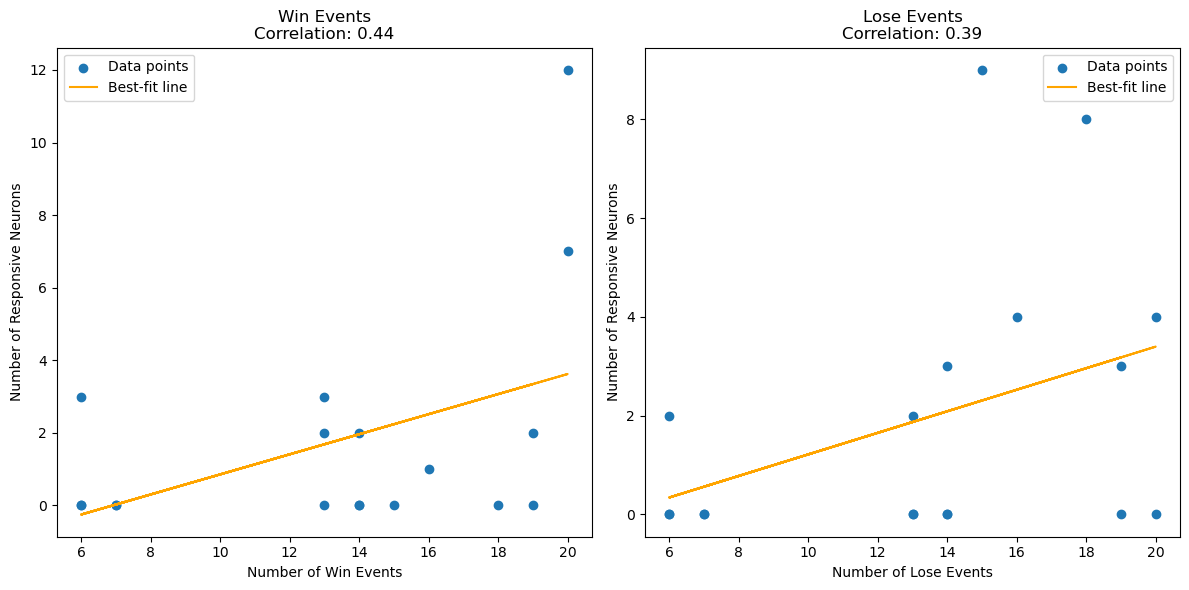

In [46]:
# Calculate best-fit lines
slope_win, intercept_win, _, _, _ = linregress(win_df['Win Count'], win_df['Win Neurons'])
slope_lose, intercept_lose, _, _, _ = linregress(lose_df['Lose Count'], lose_df['Lose Neurons'])

# Create best-fit lines for plots
line_win = slope_win * win_df['Win Count'] + intercept_win
line_lose = slope_lose * lose_df['Lose Count'] + intercept_lose

# Creating scatter plots with best-fit lines
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Win Events
axs[0].scatter(win_df['Win Count'], win_df['Win Neurons'], label='Data points')
axs[0].plot(win_df['Win Count'], line_win, color='orange', label='Best-fit line')
axs[0].set_title(f'Win Events\nCorrelation: {correlation_win:.2f}')
axs[0].set_xlabel('Number of Win Events')
axs[0].set_ylabel('Number of Responsive Neurons')
axs[0].legend()

# Lose Events
axs[1].scatter(lose_df['Lose Count'], lose_df['Lose Neurons'], label='Data points')
axs[1].plot(lose_df['Lose Count'], line_lose, color='orange', label='Best-fit line')
axs[1].set_title(f'Lose Events\nCorrelation: {correlation_lose:.2f}')
axs[1].set_xlabel('Number of Lose Events')
axs[1].set_ylabel('Number of Responsive Neurons')
axs[1].legend()

plt.tight_layout()
plt.show()